Installing packags needed for the project. We are working with the OpenAI gym Box2d environment.

In [ ]:
!pip install gym[box2d] > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender > /dev/null 2>&1
!pip install imageio==2.4.1 > /dev/null 2>&1
!pip install wandb -Uq > /dev/null 2>&1

!mkdir plots
!mkdir tmp_models

In [ ]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import torch.optim as optim
import gym
from gym import wrappers
import matplotlib.pyplot as plt
from colabgymrender.recorder import Recorder
import wandb

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4227072/45929032 bytes (9.2%)8470528/45929032 bytes (18.4%)12623872/45929032 bytes (27.5%)16867328/45929032 bytes (36.7%)19947520/45929032 bytes (43.4%)24223744/45929032 bytes (52.7%)28508160/45929032 bytes (62.1%)32645120/45929032 bytes (71.1%)36962304/45929032 bytes (80.5%)41033728/45929032 bytes (89.3%)45006848/45929032 bytes (98.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

Connect to ur Google drive, in order to save network state online, where it won't dissapear if we get kicked of Colab while running.

In [ ]:
if 1:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = 'drive/My Drive/'
else:
    drive_path = ''

wandb.login()

Mounted at /content/drive


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Creating the classes for the Q and policy ($\mu$) network.

In [ ]:
#models.py

# Value network (Q-network)
class CriticNetwork(nn.Module):
    def __init__(self, name = 'critic', chkpt_dir = 'tmp_models',
                 state_size   = (96, 96),
                 input_size   = 1,
                 conv1_dim    = 6,
                 conv2_dim    = 12,
                 cnn_kernel1  = 7,
                 cnn_kernel2  = 4,
                 pool_kernel  = 2,
                 fc1_dims     = 216,
                 fc2_dims     = 300):

        super(CriticNetwork, self).__init__()
        
        # Filepath to save the parameters of the model
        self.chkpt_dir = chkpt_dir
        self.name = name
        
        # The convolutional layers
        self.conv1 = nn.Conv2d(input_size, 16, kernel_size = 5, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride=3)
        self.conv3 = nn.Conv2d(32, 32, kernel_size = 3, stride=3)

        # Linear network
        # The weights and bias' are initiated with the Xavier uniform distribution
        self.fc1 = nn.Linear(129, 64)
        self.fc2 = nn.Linear(64, 32)
        self.q = nn.Linear(32, 1)
        
    def forward(self, state, action):
        # The first and 2nd convo + pooling layer
        state = F.relu(self.conv1(state))
        state = F.relu(self.conv2(state))
        state = F.relu(self.conv3(state))

        # Flatten the matrix to a vector, to be used in a fully-connected layer
        state_action_value = torch.cat([torch.flatten(state, 1), action[:,:1]], 1)
        state_action_value = F.relu(self.fc1(state_action_value))
        state_action_value = F.relu(self.fc2(state_action_value))
        q = self.q(state_action_value)
        
        return q

    def _cnn_size_check(self, img_size, cnn_kernel_size, pool_kernel_size):
        # If the image size is divisible by the pooling kernel, and will be
        # atleast 1 pixel big after the whole convolution process.
        if (img_size % pool_kernel_size == 0).all() and \
           (img_size > ((cnn_kernel_size-1) * pool_kernel_size)).all():
            
            # The image size after 1 full convolutional layer.
            lin_input_size = (img_size - (cnn_kernel_size-1)) / pool_kernel_size
            lin_input_size = lin_input_size.astype(int)
            return lin_input_size
        else:
            print(f"ERROR\nThe size for the linear input is wrong: {img_size}")
            
    
    def save_checkpoints(self, suffix = '', drive_dir = ''):
        checkpoint_file = os.path.join(drive_dir + self.chkpt_dir,
                                       self.name + "_ddpg" + suffix)
        torch.save(self.state_dict(), checkpoint_file)
        
    def load_checkpoints(self, suffix = '', drive_dir = ''):
        checkpoint_file = os.path.join(drive_dir + self.chkpt_dir,
                                       self.name + "_ddpg" + suffix)
        self.load_state_dict(torch.load(checkpoint_file))


class ActorNetwork(nn.Module):
    def __init__(self, name = 'actor', chkpt_dir = 'tmp_models',
                 state_size   = (96, 96),
                 input_size   = 1,
                 conv1_dim    = 6,
                 conv2_dim    = 12,
                 cnn_kernel1  = 7,
                 cnn_kernel2  = 4,
                 pool_kernel  = 2,
                 fc1_dims     = 216,
                 fc2_dims     = 300,
                 n_actions    = 2):

        super(ActorNetwork, self).__init__()
        
        # Filepath to save the parameters of the model
        self.chkpt_dir = chkpt_dir
        self.name = name
        
        # The convolutional layers
        self.conv1 = nn.Conv2d(input_size, 16, kernel_size = 5, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride=3)
        self.conv3 = nn.Conv2d(32, 32, kernel_size = 3, stride=3)

        # Linear network
        # The weights and bias' are initiated with the Xavier uniform distribution
        self.fc1 = nn.Linear(128, 64)
        f = 0.005
        torch.nn.init.uniform_(self.fc1.weight.data, -f, f)
        torch.nn.init.uniform_(self.fc1.bias.data, -f, f)
        
        
        self.mu = nn.Linear(64, n_actions)
        torch.nn.init.uniform_(self.mu.weight.data, -f, f)
        torch.nn.init.uniform_(self.mu.bias.data, -f, f)
        
        
    def forward(self, state):
        # The first and 2nd convo + pooling layer
        state = F.relu(self.conv1(state))
        state = F.relu(self.conv2(state))
        state = F.relu(self.conv3(state))
        
        # Flatten the matrix to a vector, to be used in a fully-connected layer
        prob = torch.flatten(state, 1)
        prob = F.relu(self.fc1(prob))
        
        # Run tanh on the action (-1, 1) split the acceleration into gas and breaking
        mu = torch.tanh(self.mu(prob))/4

        mu = torch.cat([mu, torch.relu(-mu[:, 1:])],1)
        mu[:, 1:] = torch.relu(mu[:, 1:])
        
        # Make the steering a fourth, as the steering is really hard
        # u[:,0] /= 4
        
        return mu

    def _cnn_size_check(self, img_size, cnn_kernel_size, pool_kernel_size):
        # If the image size is divisible by the pooling kernel, and will be
        # atleast 1 pixel big after the whole convolution process.
        if (img_size % pool_kernel_size == 0).all() and \
           (img_size > ((cnn_kernel_size-1) * pool_kernel_size)).all():
            
            # The image size after 1 full convolutional layer.
            lin_input_size = (img_size - (cnn_kernel_size-1)) / pool_kernel_size
            lin_input_size = lin_input_size.astype(int)
            return lin_input_size
        else:
            print(f"ERROR\nThe size for the linear input is wrong: {img_size}")
    
    
    def save_checkpoints(self, suffix = '', drive_dir = ''):
        checkpoint_file = os.path.join(drive_dir + self.chkpt_dir,
                                       self.name + "_ddpg" + suffix)
        torch.save(self.state_dict(), checkpoint_file)
        
        
    def load_checkpoints(self, suffix = '', drive_dir = ''):
        checkpoint_file = os.path.join(drive_dir + self.chkpt_dir,
                                       self.name + "_ddpg" + suffix)
        self.load_state_dict(torch.load(checkpoint_file))
        


In [ ]:
# utils.py
class Memory:
    def __init__(self, max_size):
        # Initiate a que for our buffer to be stored in
        self.buffer = deque(maxlen=max_size)

    def push(self, experience):
        # Store all the values in the buffer
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        # Pick "batch_size" number of elements randomly from the buffer
        # and then return them
        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return np.array(state_batch), np.array(action_batch),\
               np.array(reward_batch), np.array(next_state_batch), \
               np.array(done_batch)

    def __len__(self):
        return len(self.buffer)



def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0,i-10):(i+1)])
    plt.plot(x, running_avg, label = 'running avg')
    plt.plot(x, scores, label = 'score')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Running avg of last 10 scores')
    plt.legend(loc = 'best')
    plt.savefig(figure_file)



def preprocess(img):
    img = img.copy()
    # The 2 parts of the img
    game_img = img[:84, :, :]
    info_bar = img[84:, :, :]

    # Unify grass color
    game_img[(160 < game_img) * (game_img <= 190)] = 160
    
    # Unify the track color
    game_img[((100 <= game_img) * (game_img <= 154))] = 102

    # Make car one color
    game_img[(40 <= game_img) * (game_img <= 98)] = 50
    
    # Remove number of info bar, and replace it with the speed bar
    info_bar[3:10, 1:12, :] = info_bar[3:10, 12:13, :]

    return img


In [ ]:
# agent.py
class DDPGAgent:
    def __init__(self, lr_mu, lr_Q, gamma, tau, env, batch_size = 500,
                 noise_std  = [0.01, 0.01, 0.01],
                 noise_mean  = [0.0, 0.005, -0.05], 
                 chkpt_dir = 'tmp_models'):
        
        # Choose the device to run on
        if torch.cuda.is_available():
            print('Agent is running on GPU')
            self.device = torch.device('cuda')
        else:
            print('Agent is running on CPU')
            self.device = torch.device('cpu')
        
        # Parameters
        self.max_big_memory_size   = 10**4
        self.max_small_memory_size = batch_size
        self.gamma                 = gamma
        self.tau                   = tau
        self.batch_size            = batch_size
        
        self.min_action_val = torch.FloatTensor(env.action_space.low).to(self.device)
        self.max_action_val = torch.FloatTensor(env.action_space.high).to(self.device)
        self.noise_std      = torch.FloatTensor(noise_std).to(self.device)
        self.noise_mean     = torch.FloatTensor(noise_mean).to(self.device)
        
        
        # Randomly initialize the critic (Q) and actor (mu) network
        self.critic        = CriticNetwork(name='Critic', chkpt_dir=chkpt_dir).to(self.device)
        self.actor         = ActorNetwork(name ='Actor', chkpt_dir=chkpt_dir).to(self.device)
        self.target_critic = CriticNetwork(name='TargetCritic', chkpt_dir=chkpt_dir).to(self.device)
        self.target_actor  = ActorNetwork(name ='TargetActor', chkpt_dir=chkpt_dir).to(self.device)
        
        # Set the target networks to have the save parameters as their online version
        self.update_target_networks(tau = 1)

        # Initialize the replay buffers. Reason for the smaller is to get 
        # some recency bias
        self.big_memory   = Memory(self.max_big_memory_size)
        self.small_memory = Memory(self.max_small_memory_size)
        
        # Define the loss function and the optimizer
        self.critic_criterion = nn.MSELoss()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_Q)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=lr_mu)
        
        
    def remember(self, state, action, reward, state_next, done):
        # Change the state dimensions to be correct, aka.:(channel, height, width)
        state = np.transpose(state, (2, 0, 1))
        state_next = np.transpose(state_next, (2, 0, 1))
        
        # Add an extra dimension to "reward and "done",
        # so it matches the other tensors dimension
        reward = np.array([reward])
        done   = np.array([done])
        
        # Push the experiences to the buffer
        experience = (state, action, reward, state_next, done)
        self.small_memory.push(experience)
        
    def move_small_buffer_to_big(self):
        # Move small buffer to big, by popping each element of the small buffer
        # into the big one
        while len(self.small_memory) != 0:
            self.big_memory.push(self.small_memory.buffer.pop())
        
        
    def getAction(self, state, evaluate = False):
        self.actor.eval()
        
        # Get an action from the actor network of this specific state
        state   = torch.FloatTensor(state).to(self.device)
        state   = torch.permute(state[None, :], (0, 3, 1, 2))
        with torch.no_grad():
            actions = self.actor.forward(state)
        
        # If we are still training add noise, to help with exploration
        if not evaluate:
            #actions += torch.normal(mean = 0.0, std  = 0.1, size = actions.shape).to(self.device)
                        
            actions += torch.normal(mean = self.noise_mean * (actions != 0),
                                    std  = self.noise_std * (actions != 0)).to(self.device)
            
            # Clip the action values to not exceed the boundaries
            actions = torch.clamp(actions, min = self.min_action_val/4,
                                           max = self.max_action_val/4)
        
        self.actor.train()
        
        return actions.cpu().detach().numpy()
        

    def update_target_networks(self, tau = None):
        if tau is None:
            tau = self.tau

        # Extract the weights and biases of the networks
        actor_params         = self.actor.state_dict()
        critic_params        = self.critic.state_dict()
        target_actor_params  = self.target_actor.state_dict()
        target_critic_params = self.target_critic.state_dict()
        
        # Iterate over the mu (actor) network and soft-update the parameters
        for name in actor_params:
            actor_params[name] = tau * actor_params[name].clone() +\
                                 (1-tau) * target_actor_params[name].clone()
                                 
        self.target_actor.load_state_dict(actor_params)
        
        # Iterate over the Q (critic) network and soft-update the parameters
        for name in critic_params:
            critic_params[name] = tau * critic_params[name].clone() +\
                                 (1-tau) * target_critic_params[name].clone()
                                 
        self.target_critic.load_state_dict(critic_params)
        

    def update(self, recency_buffer : bool):
        # Get a "batch_size" number of samples from our memory buffer
        if recency_buffer:
            state, action, reward, state_next, done = self.small_memory.sample(self.batch_size)
        else:
            state, action, reward, state_next, done = self.big_memory.sample(self.batch_size)
        
        state      = torch.FloatTensor(state).to(self.device)
        action     = torch.FloatTensor(action).to(self.device)
        reward     = torch.FloatTensor(reward).to(self.device)
        state_next = torch.FloatTensor(state_next).to(self.device)
        done       = torch.IntTensor(done).to(self.device)
        
        # Put the network into evaluation
        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        
        
        # Q loss
        # Calculate y_i (Q-val/(total future reward) for the target net)
        with torch.no_grad():
          target_actions    = self.target_actor.forward(state_next)
          # target_actions    = torch.cat([target_actions, target_actions*0+0.1, target_actions*0],1)
          target_critic_val = self.target_critic.forward(state_next, target_actions)
          y_i = reward + self.gamma * target_critic_val * (1-done)
        #assert not y_i.requires_grad
        
        # Set the critic network back into training mode
        self.critic.train()
        
        # With y_i, we just need Q_val of our online critic net.
        # We do MSE to find the critic loss
        self.critic_optimizer.zero_grad()
        critic_val  = self.critic.forward(state, action)
        critic_loss = self.critic_criterion(critic_val, y_i)
        
        # Backpropegate the loss through the network
        #self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        

        # Policy loss
        # The policy loss is found by taking the mean of the gradient ascendt
        # of the critic network.
        self.critic.eval()
        self.actor_optimizer.zero_grad()
        mu = self.actor.forward(state)
        # mu = torch.cat([mu, mu*0+0.1, mu*0],1)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = torch.mean(actor_loss)
        
        # Backpropegate the loss through the network
        actor_loss.backward()
        self.actor_optimizer.step()

        
        # Lastly we update the target networks
        self.update_target_networks()

        
        return (critic_loss, actor_loss, critic_val, y_i)
        
        
        
    def save_models(self, suffix = '', drive_dir = ''):
        print('\n# # # # #  Saving checkpoint  # # # # #\n')
        self.critic.save_checkpoints(suffix, drive_dir)
        self.actor.save_checkpoints(suffix, drive_dir)
        self.target_critic.save_checkpoints(suffix, drive_dir)
        self.target_actor.save_checkpoints(suffix, drive_dir)
    
    def load_models(self,  suffix = '', drive_dir = ''):
        print('\n# # # # #  Loading checkpoint  # # # # #\n')
        self.critic.load_checkpoints(suffix, drive_dir)
        self.actor.load_checkpoints(suffix, drive_dir)
        self.target_critic.load_checkpoints(suffix, drive_dir)
        self.target_actor.load_checkpoints(suffix, drive_dir)

In [ ]:
# main.py

######################
#     Parameters     #
######################
gamma = 0.99
tau = 0.005
lr_mu, lr_Q = 1e-5, 6e-6
episodes = 2000
batch_size = 100
step_size = 10000
verbose_freq = 50

figure_file = 'plots/CarRacing_rewards.png'

do_wandb = False

if do_wandb:
    # Initialize our WandB client
    wandb_client = wandb.init(project="DL_CarRacing_1D")
    
    # define our custom x axis metric
    wandb.define_metric("Loss_step")
    
    # define which metrics will be plotted against it
    wandb.define_metric("critic_loss_short", step_metric="Loss_step")
    wandb.define_metric("critic_loss_long", step_metric="Loss_step")
    wandb.define_metric("actor_loss_short", step_metric="Loss_step")
    wandb.define_metric("actor_loss_long", step_metric="Loss_step")

######################
#     Environment    #
######################
env = gym.make('CarRacing-v2', new_step_api=True) # Create environment
env.reset(options={"randomize": False}, seed = 42) # Reset environment
env = wrappers.GrayScaleObservation(env, keep_dim = True)


######################
#       Agent        #
######################
agent = DDPGAgent(gamma = gamma, tau = tau,lr_mu = lr_mu,
                  lr_Q = lr_Q, env = env, batch_size = batch_size)

print(f'Online {agent.critic}')
print(f'Online {agent.actor}')

#######################
# Training parameters #
#######################
rewards = [0]
best_score = 0
no_reward_counter = 0

# Wandb variables
metrics = []


#######################
#      Main loop      #
#######################

for e in range(episodes):

    state = env.reset()   # (96, 96, 1) image
    state = preprocess(state)
    score = 0

    for step in range(step_size):
        # Sample an action from our actor network
        action = agent.getAction(state)[0]
        train_action = action*4
              
        # Add a constant speed and no brake
        #action = np.append(action, [0.05, 0])
        
        
        # Take the action in our current state
        state_next, reward, done, done2, _ = env.step(action)
        state_next = preprocess(state_next)
        # plt.imshow(state_next, cmap = 'gray')
        # plt.show()
        
        env.render()
        
        # If we dont get a positive reward in 200 steps, we reset
        
        if reward < 0:
            no_reward_counter += 1
            if no_reward_counter > 100:
                print('No positive reward in 100 steps; RESET')
                done = True
        else:
            no_reward_counter = 0
        
        
        # Position of the car
        x = env.car.hull.position[0]
        y = env.car.hull.position[1]
        
        # Add the reward from the step to our score
        score += reward

        if do_wandb:
            metrics.append({"reward"   : reward,
                            "Score"    : rewards[-1],
                            "Steering" : action[0],
                            "Gas"      : action[1],
                            "Breaking" : action[2],
                            "x pos"    : x,
                            "y pos"    : y,
                           })

        
          
        
        # train_state       = preprocess(state)
        # train_state_next  = preprocess(state_next)
        # plt.imshow(train_state, cmap = 'gray')
        # plt.show()
        
        # Throw all our variables in the memory
        agent.remember(state, train_action, reward, state_next, np.array([done, done2]).any())
        

        # When we have enough state-action pairs, we can update our online nets
        if len(agent.small_memory) == batch_size:
            print('Updating the networks...')
            # Update network with small buffer for recency
            smallB_metrics = agent.update(recency_buffer = True)
            
            # Move small buffer to big, and reset small buffer
            agent.move_small_buffer_to_big()
            
            # Update network with big buffer
            bigB_metrics = agent.update(recency_buffer = False)
            
            if do_wandb:
                for i in range(batch_size):
                    metrics[i].update({
                             "Q-val (short term)": smallB_metrics[2][i],
                             "y_i (short term)"  : smallB_metrics[3][i],
                             "Q-val (long term)" : bigB_metrics[2][i],
                             "y_i (long term)"   : bigB_metrics[3][i]})
                    wandb_client.log(metrics[i])
                metrics = []
            
                wandb_client.log({'critic_loss_short' : smallB_metrics[0]})
                wandb_client.log({'critic_loss_long'  : bigB_metrics[0]})
                wandb_client.log({'actor_loss_short'  : smallB_metrics[1]})
                wandb_client.log({'actor_loss_long'   : bigB_metrics[1]})
            

        # The next state, is now our current state.
        state = state_next
        
        # How far into the episode we are 
        if (step+1) % verbose_freq == 0: print(f'Step {step+1} done!')
        
        # if the environment terminates before the step_size, we break
        if np.array([done, done2]).any():
            print('## ## Terminated at:')
            break
        
        
    # After each episode we store the score        
    rewards.append(score)
    
    # The avg score of the last 10 episodes
    avg_score = np.mean(rewards[-10:])
    
    print(f'Episode {e+1}, score: {score:.1f}, avg_score: {avg_score:.1f}')
    
    # Save the model, every 100th episode
    if (e+1) % 100 == 0: agent.save_models(suffix = f'_episode_{e+1}',
                                           drive_dir = drive_path)
    
    # Save the best model
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models(drive_dir = drive_path)


wandb_client.finish()

# Save the final paramters of the model
agent.save_models(suffix = '_final', drive_dir = drive_path)

Streaming af output blev afkortet til de sidste 5000 linjer.
Step 1000 done!
## ## Terminated at:
Episode 1372, score: 260.9, avg_score: 275.3
Step 50 done!
Updating the networks...
Step 100 done!
Step 150 done!
Updating the networks...
Step 200 done!
Step 250 done!
Updating the networks...
Step 300 done!
Step 350 done!
Updating the networks...
Step 400 done!
Step 450 done!
Updating the networks...
Step 500 done!
Step 550 done!
Updating the networks...
Step 600 done!
Step 650 done!
Updating the networks...
Step 700 done!
Step 750 done!
Updating the networks...
Step 800 done!
Step 850 done!
Updating the networks...
Step 900 done!
Step 950 done!
Updating the networks...
Step 1000 done!
## ## Terminated at:
Episode 1373, score: 298.5, avg_score: 283.0
Step 50 done!
Updating the networks...
Step 100 done!
Step 150 done!
Updating the networks...
Step 200 done!
Step 250 done!
Updating the networks...
Step 300 done!
Step 350 done!
Updating the networks...
Step 400 done!
Step 450 done!
Updatin

Breaking,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█▇
Gas,▅▁▄▁▁▄▄▆▆▆▅▁▄▁▁▆▁▁▅▃▇▇▆▄▁▇█▄▄▇▇▁▂▁▂▁▆▁▁▁
Q-val (long term),▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▄▆▅▅▇▇▇███▇██▅▆▇
Q-val (short term),▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇███▇▇█▅▇▆
Score,▁▁▁▁▁▁▁▁▁▄▃▅▆▂▅▇▆▇▇▇▇▇█▇▇▆▇▅▄▆▃▆▅▆▅▁▂▁▁▁
Steering,▃▁▁▂█▆▅▄▄▂▅▄▅▄▄▅▄▄▃▅▄▄▄▄▄▅▅▅▄▁▅▄▄▅▄█▅▂██
actor_loss_long,▇█████████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▂▂▂▂
actor_loss_short,▇█████████▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▃▂▁▂▁▁▁▂▂▃
critic_loss_long,▄▁▂▁▃▂▂▃▃▄▃▄▄▄▅▅▆▆▆▇▇▆▄█▆▅▅▃▄▆█▆▅▅▄▃▅▁▆▁
critic_loss_short,▂▂▂▁▁▃▃▁▃▅▃▃▆▃█▃▅▄▅▃▃▄▃█▆▄▅▆▃▄▅▆▃▄▃▂▇▅▅▄
reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁



# # # # #  Saving checkpoint  # # # # #



In [ ]:
wandb_client.finish()

# Save the final paramters of the model
agent.save_models(suffix = '_final', drive_dir = drive_path)

Breaking,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Gas,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Q-val (long term),▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▄▅▅▆▅▅▅▆▅▆▃▇▇▇▇███
Q-val (short term),▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▃▃▃▃▄▄▅▅▅▅▅▄▅▆▅▇▆▇▇▇█▆█▅█
Score,▁▁▁▁▁▁▁▁▂▂▁▄█▃▅▂▄▂▂▇▇▃▅▂▂▄▆▆▆▇▆▅▇▂▆▆▂▆▆▃
Steering,▅▅▅▅▆▆▅▅▆▆▅▄▄▆▃▆▆▅▇▃▆▁▇▆▃▇▄█▅█▅▃▁▁▃▃█▂█▃
actor_loss_long,██████████▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
actor_loss_short,█████████▇▇▇▇▆▇▆▇▆▅▅▅▆▅▅▄▅▄▃▃▃▄▂▃▄▂▂▃▁▁▁
critic_loss_long,▂▃▂▃▂▁▂▂▂▃▃▃▅▄▄▅▅▄▄▅▄▅▅▆▅▅▆▅▅▄▄▅█▅▄▄▄▅▄▄
critic_loss_short,▃▂▂▃▃▂▃▁▁▃▆▅▄▄▂▅▂▇▆█▆▁▆▇▆▂▄▅▄▆█▄▇▂▆▇▅▅▅█
reward,▁▁▁▁▁▁▁▁▁▁█▁▇▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁



# # # # #  Saving checkpoint  # # # # #



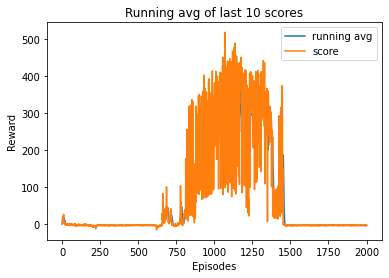

In [ ]:
# Save the final paramters of the model
#agent.save_models(suffix = 'final', drive_dir = drive_path)
x = [i + 1 for i in range(len(rewards))]
plot_learning_curve(x, rewards, figure_file)

In [ ]:
# For the environment recorder.
try:
  env.close()
except: 
  pass
env = gym.make('CarRacing-v2', new_step_api=True) # Create environment
env = Recorder(env, "./video", auto_release = False) # To display environment in Colab
env.reset(options={"randomize": False}, seed = 42) # Reset environment
env = wrappers.GrayScaleObservation(env, keep_dim = True)

# Agent
chkpt_dir = 'tmp_models'
agent = DDPGAgent(gamma = gamma, tau = tau, lr_mu = lr_mu,
                  lr_Q = lr_Q, env = env, batch_size = batch_size,
                  chkpt_dir=chkpt_dir)
agent.load_models(suffix = '_episode_1100', drive_dir = drive_path)

score = 0
state = env.reset()

for step in range(step_size):
    # Sample an action from our actor network
    action = agent.getAction(state)[0]
    
    # Add a constant speed and no brake
    action = np.append(action, [0.05, 0])
    
    # Take the action in our current state
    state_next, reward, done, done2, _ = env.step(action)

    # Update score
    score += reward
    
    # The next state, is now our current state.
    state = state_next
    
    # if the environment terminates before the step_size, we break
    if np.array([done, done2]).any():
        print(f'Sim terminated')
        break

print(f'Score for this episode = {score:.1f}')

env.release() # stops the recording and saves it as a proper .mp4 file
env.close() # Close environment
env.play()

Agent is running on GPU

# # # # #  Loading checkpoint  # # # # #

Sim terminated
Score for this episode = 362.3


  warnings.warn("Warning: in file %s, "%(self.filename)+

